# Filtering and resampling SIA data, observations and models

### Author: Chris Wyburn-Powell, [github](https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_filtering_resampling.ipynb)

**Input**: <br>
- Models: Arctic SIA from six models of the CLIVAR Large Ensemble archive (CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1), as computed in [another notebook](https://github.com/chrisrwp/synthetic-ensemble/SIA/SIC_to_SIA_models.ipynb)
- Observations: Arctic SIA from 4 observational datasets: Climate Data Record (CDR), NASA Bootstrap (BT), NASA Team (NT), and Hadley Centre Sea Ice (HadISST1), as computed in  [another notebook](https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_calculations_observations.ipynb)

**Output**: <br>
- Detrended SIA for models and observations using the individual datasets or member or the average observational dataset or ensemble mean
- Resampled SIA 10,000 times wiht a 2 year bootstrap size
- **$\sigma_{LE}$**  : Standard deviations of detrended models without resampling
- **$\sigma_{mem}$** : Standard deviations of detrended resampled models
- **$\sigma_{obs}$** : Standard deivations of detrended resampled observations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import xarray as xr
import scipy.signal as signal 
import datetime
import scipy.stats as stats
import math as m

# Load Data

In [3]:
data_path = '/glade/scratch/cwpowell/Synthetic_ensemble/'

model_names  = ['CanESM2', 'CESM1', 'CSIRO_MK36', 'GFDL_CM3', 'GFDL_ESM2M', 'MPI_ESM1' ]
mem_len      = [50,        40,      30,           20,         30,           100        ]
model_starts = [1950,      1920,    1850,         1920,       1950,         1850       ]
month_names_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['m',     'b',   'g',        'orange',  'k',        'tab:olive' ]

In [4]:
#load observational data
CDR  = xr.open_dataset(data_path+'Raw_data/observations/NSIDC_CDR_v4/SIA_SIE_CDR_BT_NT_79-20_filled.nc')
HadISST1 = xr.open_dataset(data_path+'Raw_data/observations/HadISST/HadISST1_SIA_SIE_79-20_filled.nc')

obs_SIA = xr.Dataset({'CDR':CDR['CDR_SIA'].copy(), 'BT':CDR['BT_SIA'].copy(), 
                      'NT':CDR['NT_SIA'].copy(), 'HadISST1':HadISST1['SIA'].copy()})

obs_SIA_keys = list(obs_SIA.keys())

#load model data
SIA = xr.open_dataset(data_path+'SIA/SIA_SIE_SIV/CLIVAR_SIA_1850_2100_RCP85.nc')

# Define functions for resampling and filtering

In [6]:
def resample_boot1(time_period, data):
    '''
    Resample a 1D time series using a 2 year block boostrap size
    
    Parameters
    ----------
    time_period : integer,
        For 1979-2020 use 42 as the total number of years in that time period
    data : 1 dimensional xarray dataarray,
        For 1979-2020 this is an array of shape [42] 
    
    Returns
    ----------
        2D xarray dataarray object of 1000 resamplings of the input data, shape: (time_period, 1000)
    ''' 
    
    resampled = np.random.choice(data, (time_period, 1000), replace=True)
    
    return(resampled)

In [7]:
def resample_boot2(time_period, data, resamp_n):
    '''
    Resample a 1D time series using a 2 year block boostrap size with replacement
    
    Parameters
    ----------
    time_period : integer,
        For 1979-2020 use 42 as the total number of years in that time period
    data : 1 dimensional xarray dataarray,
        For 1979-2020 this is an array of shape [42] 
    resamp_n: int
        Number of resamplings
    
    Returns
    ----------
        2D xarray dataarray object of n resamplings of the input data, shape: (time_period, resamp_n)
    '''  
    #create an xarray dataarray of indexes for half the length of the time period, year_i coordinates 1,3,5...
    boot_2_first_ind = xr.DataArray(data   = np.random.randint(0,time_period-2, (resamp_n,int(time_period/2))), 
                                    coords = {'resampling':np.arange(1,resamp_n+1,1), 'year_i':np.arange(1,time_period+1,2)},
                                    dims   = ['resampling', 'year_i'])

    #create an identical dataarray but with each element incremented by 1, year_i coordinates 2,4,6....
    boot_2_second_ind = (boot_2_first_ind+1).copy()
    boot_2_second_ind['year_i'] = np.arange(2,time_period+2,2)

    #concatenate the two arrays with the coordinates in order, this allows a 2 year block boostrap size
    all_boot_2_ind = xr.concat((boot_2_first_ind, boot_2_second_ind), dim='year_i').sortby('year_i')
    
    #create an array with the starting element of the flattened array for each resampling 0, 42, 84...
    ind_base = np.repeat(np.arange(0,time_period*resamp_n,time_period),time_period)
    
    #add together the base indexes (0,42,84...) with the randomly chosen indexes within the original data
    ind_1_d = np.ravel(all_boot_2_ind) + ind_base
    
    #copy the original data 1000 times as a 1D array so it will have the same indexes as we just made for ind_1_d
    data_1000 = np.ravel(np.tile(data,(time_period,resamp_n)))
    
    #select the randomly generated indexes from the flattened copied original data, reshape and save to xarray dataarray
    resampled_boot_2 = xr.DataArray(data = np.reshape(data_1000[ind_1_d], (resamp_n, time_period)),
                                    coords = {'resampling':np.arange(1,resamp_n+1,1), 'year_i':np.arange(1,time_period+1,1)},
                                    dims   = ['resampling', 'year_i'])

    return(resampled_boot_2)

In [8]:
def filt_lowpass(data, sample_freq, cutoff, order):
    '''
    Filter a 1D time series using a lowpass Butterworth filter. 
    Uses scipy.signal.butter and scipy.signal.filtfilt
    
    Parameters
    ----------
    data : 1 dimensional xarray dataarray,
        For 1979-2020 this is an array of shape [42] 
    sample_freq: float,
        The sampling frequency of the input data, typically sample_freq=1 [year]
    cutoff: float,     
        The fraction of the nyquist frequency. To filter with a 2-year lowpass filter with sample_freq=1, cutoff=0.25
    order: int
        The order of the Butterworth filter, typically 4-6
    
    Returns
    ----------
        1D numpy array of the same shape as the input data
    '''  
    
    nyquist = sample_freq / 2 # 0.5 times the sampling frequency
    b, a = signal.butter(order, cutoff, btype='lowpass') #low pass filter
    filtered = signal.filtfilt(b, a, data) #apply the filter forward and backward
    
    return(filtered)

# Filter
## Observations

In [9]:
obs_filt_2yr = {}
for key in obs_SIA_keys:  
    all_month_filtered = []
    for month_ in np.arange(1,13):
        filt_2_yr = filt_lowpass(data=obs_SIA[key].sel(time=obs_SIA['time.month']==month_), 
                                 sample_freq=1, cutoff=0.25, order=5)

        all_month_filtered.append(obs_SIA[key].sel(time=obs_SIA['time.month']==month_) - filt_2_yr)


    obs_filt_2yr[key] = (xr.concat((all_month_filtered), dim='time'))
obs_filt_2yr = xr.Dataset(obs_filt_2yr)

## Models

In [51]:
start_yr = 1979
end_yr   = 2020

all_model_filt_2yr = {}

for model_i, model_name in enumerate(model_names):
    
    filt_2yr_list = []
    
    for month_ in np.arange(1,13):
        
        if model_name == 'MPI_ESM1': #100 elements in member dimension so can't select all of those for MPI ESM1
            model_month = SIA[model_name].sel(time=SIA['time.month']==month_).sel(time=slice(str(start_yr),str(end_yr)))
        else:
            model_month = SIA[model_name].sel(time=SIA['time.month']==month_).sel(time=slice(str(start_yr),str(end_yr))).sel(member=slice('1',str(mem_len[model_i])))
        
        #filter all members by the ensemble mean trend
        filt_2_yr_month = filt_lowpass(data=model_month, sample_freq=1, cutoff=0.25, order=5)

        #detrend the individual members with the filtered time series
        filt_2yr_list.append(model_month - filt_2_yr_month)
        
    all_model_filt_2yr[model_name] = xr.concat((filt_2yr_list), dim='time')
    
all_model_filt_2yr = xr.Dataset(all_model_filt_2yr)

## Resample all detrended observational data sets


In [10]:
#calculate the resamplings of all observational datasets and months
#to change the bootstrap size, change the function names: [resample_boot2, resample_boot1]

obs_resample_filt_2yr = {}

for key in obs_SIA_keys:   

    resampled_month = []

    for month_ in np.arange(1,13):
        resampled_month.append(resample_boot2(42, obs_filt_2yr[key].sel(time=obs_filt_2yr['time.month']==month_), 10000))


    obs_resample_filt_2yr[key] = xr.concat((resampled_month), dim='month')


obs_resample_filt_2yr = xr.Dataset(obs_resample_filt_2yr)
obs_resample_filt_2yr['month'] = np.arange(1,13)

## Resampling all models

In [65]:
mem_resample_filt_2yr = {}

for model_i, model_name in enumerate(model_names):
    print(datetime.datetime.now(), model_name)
    
    resampled_month = []
    for month_ in np.arange(1,13):
        
        resampled_month_model = []
        for member_ in np.arange(1,mem_len[model_i]+1):
            resampled_month_model.append(resample_boot2(42, all_model_filt_2yr[model_name].sel(time=all_model_filt_2yr['time.month']==month_).sel(member=member_), 10000))
        
        resampled_month.append(xr.concat((resampled_month_model),dim='member').std('year_i')) 

    mem_resample_filt_2yr[model_name] = xr.concat((resampled_month), dim='month')
    mem_resample_filt_2yr[model_name]['member'] = np.arange(1,mem_len[model_i]+1)

mem_resample_filt_2yr = xr.Dataset(mem_resample_filt_2yr)
mem_resample_filt_2yr['month'] = np.arange(1,13)

2022-03-16 15:59:38.032553 CanESM2
2022-03-16 16:00:15.607590 CESM1
2022-03-16 16:00:45.177528 CSIRO_MK36
2022-03-16 16:01:07.482627 GFDL_CM3
2022-03-16 16:01:22.427990 GFDL_ESM2M
2022-03-16 16:01:44.811492 MPI_ESM1


### Compute $\sigma$ and $\mu$

In [111]:
sigma_obs_10000 = obs_resample_filt_2yr.std('year_i').std('resampling')
mu_obs_10000    = obs_resample_filt_2yr.std('year_i').mean('resampling')

sigma_mem_10000 = mem_resample_filt_2yr.std('resampling')
mu_mem_10000    = mem_resample_filt_2yr.mean('resampling')

sigma_LE_10000 = all_model_filt_2yr.groupby('time.month').std('time').std('member')

### Save $\sigma$ and $\mu$ calculations to NetCDF

In [118]:
sigma_mem_10000.attrs = {'Description': 'Resampled Arctic sea ice area (SIA) for the large ensemble models: CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1, 1979-2020. Standard deviation across resampling year and across resampling. Detrended by a Butterworth lowpass filter with a 2 year cutoff. Resampling is done 10000 times with a 2 year bootstrap size.', 
                         'Units'      : 'million square km',
                         'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                         'Data source': 'CLIVAR Large Ensemble Archive, doi:10.1038/s41558-020-0731-2',
                         'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_filtering_resampling.ipynb'}

sigma_mem_10000.to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_mem_2yr_filter_10000.nc')


mu_mem_10000.attrs = {'Description': 'Resampled Arctic sea ice area (SIA) for the large ensemble models: CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1, 1979-2020. Standard deviation across resampling year and mean of resamplings. Detrended by a Butterworth lowpass filter with a 2 year cutoff. Resampling is done 10000 times with a 2 year bootstrap size.', 
                      'Units'      : 'million square km',
                      'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                      'Data source': 'CLIVAR Large Ensemble Archive, doi:10.1038/s41558-020-0731-2',
                      'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_filtering_resampling.ipynb'}

mu_mem_10000.to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Mu_mem_2yr_filter_10000.nc')

In [120]:
sigma_obs_10000.attrs = {'Description': 'Resampled Arctic sea ice area (SIA) for the four observational datasets: Climate Data Record (CDR), NASA Bootstrap (BT), NASA Team (NT), Hadley Centre Sea Ice (HadISST1), years 1979-2020. Standard deviation across resampling year and across resampling. Detrended by a Butterworth lowpass filter with a 2 year cutoff. Resampling is done 10000 times with a 2 year bootstrap size.', 
                         'Units'      : 'million square km',
                         'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                         'Data source': 'DOIs - CDR, BT, NT:10.7265/efmz-2t65, HadISST1:10.1029/2002JD002670',
                         'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_filtering_resampling.ipynb'}

sigma_obs_10000.to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_obs_2yr_filter_10000.nc')


mu_obs_10000.attrs = {'Description': 'Resampled Arctic sea ice area (SIA) for the four observational datasets: Climate Data Record (CDR), NASA Bootstrap (BT), NASA Team (NT), Hadley Centre Sea Ice (HadISST1), years 1979-2020. Standard deviation across resampling year and mean of resamplings. Detrended by a Butterworth lowpass filter with a 2 year cutoff. Resampling is done 10000 times with a 2 year bootstrap size.', 
                      'Units'      : 'million square km',
                      'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                      'Data source': 'DOIs - CDR, BT, NT:10.7265/efmz-2t65, HadISST1:10.1029/2002JD002670',
                      'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_filtering_resampling.ipynb'}

mu_obs_10000.to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Mu_obs_2yr_filter_10000.nc')

In [135]:
sigma_LE_10000.attrs = {'Description': 'Variability of Arctic sea ice area (SIA) for the four the large ensemble models: CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1, 1979-2020. Standard deviation with respect members. Computed on the detrended standard deviations with respect to time for each month, then the standard deviation across members is taken. Detrended by a Butterworth lowpass filter with a 2 year cutoff.', 
                        'Units'      : 'million square km',
                        'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                        'Data source': 'CLIVAR Large Ensemble Archive, doi:10.1038/s41558-020-0731-20',
                        'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_filtering_resampling.ipynb'}

sigma_LE_10000.to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_LE_2yr_filter_10000.nc')

### Load data made from linear detrened resampling or filtered data

In [17]:
# sigma_LE_individual = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_LE_individual_79-20.nc')
# sigma_mem_individual = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_mem_individual_10000.nc')
# sigma_obs_individual = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_obs_individual_10000.nc')

sigma_LE_ensemble = xr.open_dataset('/glade/campaign/univ/ucub0084/Synthetic_ensemble/SIA/SIA_resampled/Sigma_LE_ensemble_79-20.nc')
sigma_mem_ensemble = xr.open_dataset('/glade/campaign/univ/ucub0084/Synthetic_ensemble/SIA/SIA_resampled/Sigma_mem_ensemble_79-20.nc')

# mu_mem_individual = xr.open_dataset(data_path+'SIA/SIA_resampled/Mu_mem_individual_10000.nc')
# mu_obs_individual = xr.open_dataset(data_path+'SIA/SIA_resampled/Mu_obs_individual_10000.nc')

# sigma_LE_filter = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_LE_2yr_filter_10000.nc')
# sigma_mem_filter = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_mem_2yr_filter_10000.nc')
# sigma_obs_filter = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_obs_2yr_filter_10000.nc')

# Remake Figure 10 and mem/obs ratios

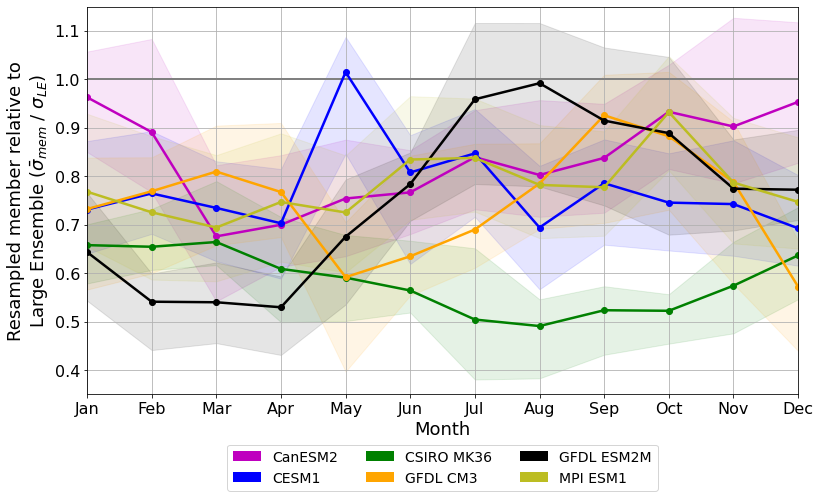

In [19]:
#plot sigma ratios with median and interquartile ranges - Figure 10
LE_mem = 1

upper_quart = np.array(mem_len)*0.75
lower_quart = np.array(mem_len)*0.25

sig_LE  = sigma_LE_ensemble.copy()
sig_mem = sigma_mem_ensemble.copy()
# sig_obs = sigma_obs_filter.copy()


fig = plt.figure(figsize=[11.5,7])
plt.axhline(1, c='0.5', linewidth=2)

for model_i, model_name in enumerate(model_names):

    #define the upper and lower quarties of sigma_mem members
    upper = sig_mem[model_name].where(sig_mem[model_name].rank('member')==m.floor(upper_quart[model_i])).max('member')
    lower = sig_mem[model_name].where(sig_mem[model_name].rank('member')==m.ceil(lower_quart[model_i])).max('member')

    if LE_mem == 1: #plot LE/mem
        plt.plot(month_names_short, sig_mem[model_name].median('member')/sig_LE[model_name], 
                 c=colors[model_i], linewidth=2.5, marker='o', markersize=6)

        plt.fill_between(month_names_short, upper/sig_LE[model_name], 
                         lower/sig_LE[model_name], color=colors[model_i], alpha=0.1)

    else: #plot mem/obs
        plt.plot(month_names_short, sig_mem[model_name].median('member')/sig_obs[obs_dataset].values, 
                 c=colors[model_i], linewidth=2, marker='o')

        plt.fill_between(month_names_short, lower/sig_obs[obs_dataset].values, 
                         upper/sig_obs[obs_dataset].values, color=colors[model_i], alpha=0.1)

#########################################################################

plt.xticks(np.arange(0,12,1))
plt.grid()
plt.xlim(0,11)
if LE_mem == 1:
    plt.ylim(0.35,1.15) #0.4,1.2 for interquartile range
else:
    plt.ylim(0.3,2.4) #0.3, 2.6 for interquartile range
plt.xlabel('Month', fontsize=18)
if LE_mem == 1:
    plt.ylabel('Resampled member relative to'+'\n'+r'Large Ensemble ($\bar{\sigma}_{mem} \ / \ \sigma_{LE}$)', fontsize=18)
else:
    plt.ylabel('Model relative to observations', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

legend_elements = [Patch(facecolor=colors[0], label='CanESM2'),
                   Patch(facecolor=colors[1], label='CESM1'),
                   Patch(facecolor=colors[2], label='CSIRO MK36'),
                   Patch(facecolor=colors[3], label='GFDL CM3'),
                   Patch(facecolor=colors[4], label='GFDL ESM2M'),
                   Patch(facecolor=colors[5], label='MPI ESM1'),]

extra_legend = plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.24), loc='lower center', borderaxespad=-0.25, ncol=3, fontsize=14)

plt.tight_layout()

fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/figures/Resampled_figures/Ratio_LE_mem_medians_iq_range_ensemble.pdf', bbox_inches='tight')

## Compare $\sigma_{obs}$ and $\sigma_{mem}$ from detrending and filtering - Figure 5

In [89]:
obs_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
month_names_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['m',     'b',   'g',        'orange',  'k',        'tab:olive' ]
member_numbers      = [50,        40,      30,           20,         30,           100        ]

In [151]:
sigma_mu = 'mu'

if sigma_mu == 'sigma':
    mem = sigma_mem_individual.copy()
    obs = sigma_obs_individual.to_array().sel(variable=['CDR','BT','NT','HadISST1'])
else:
    mem = mu_mem_individual.copy()
    obs = mu_obs_individual.to_array().sel(variable=['CDR','BT','NT','HadISST1'])
    
fig = plt.figure(figsize=[14,6])

for model_i, model_name in enumerate(model_names):
    boxplot_model = np.empty((member_numbers[model_i],12))
    
    for memb_i, memb in enumerate(np.arange(1,member_numbers[model_i]+1)):    
        boxplot_model[memb_i] = mem[model_name].sel(member=memb).values
    
    b_plot = plt.boxplot(boxplot_model, widths=0.07, positions=np.arange(0.735+model_i*0.1,12.735+model_i*0.1,1), 
                         whis=(0,100), labels=month_names_short, patch_artist=True);
    
    #set the colors
    for patch in b_plot['boxes']: 
        patch.set_facecolor(colors[model_i]) 
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(b_plot[element], color=colors[model_i], linewidth=1.5)
        
    plt.setp(b_plot['medians'], color='0.8', linewidth=2)
    
marker_list = ['o',8,9,'d','s']
for var_i in range(4):
    for month_ in np.arange(1,13):
        plt.plot([-0.35+month_, 0.35+month_], [obs.isel(variable=var_i).sel(month=month_), obs.isel(variable=var_i).sel(month=month_)], c='r', alpha=1, zorder=9)
#     plt.scatter(np.arange(0.6,12.6), obs.isel(variable=var_i), c='r', marker=marker_list[var_i])

legend_elements = [Patch(facecolor=colors[0], label='CanESM2'),
                   Patch(facecolor=colors[1], label='CESM1'),
                   Patch(facecolor=colors[2], label='CSIRO MK3.6'),
                   Patch(facecolor=colors[3], label='GFDL CM3'),
                   Patch(facecolor=colors[4], label='GFDL ESM2M'),
                   Patch(facecolor=colors[5], label='MPI ESM1'),
                   Patch(facecolor='r', label='Observations')]

extra_legend = plt.legend(handles=legend_elements, bbox_to_anchor=(0.01, 0.97), loc='upper left', borderaxespad=0, ncol=2, fontsize=14)
plt.gca().add_artist(extra_legend);
    
plt.xticks(np.arange(1,13), fontsize=16)
plt.xlabel('Month', fontsize=18)
plt.yticks(fontsize=16)

if sigma_mu == 'sigma':
    plt.ylim(0.01,0.142) #for sigma
    plt.ylabel(r'$\bar{\sigma}_{mem} \ or \ \sigma_{obs} \ \ [10^6 \ km^2]$', fontsize=18);
else:
    plt.ylim(0.1,0.85) #for mu
    plt.ylabel(r'$\bar{\mu}_{mem} \ or \ \mu_{obs} \ \ [10^6 \ km^2]$', fontsize=18);

plt.tight_layout()